<a href="https://colab.research.google.com/github/srivatsan88/model-deployment/blob/master/QAT_Tensorflow_GPU_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is code for demo shown in video - https://www.youtube.com/watch?v=4J_FW5xQDUk

In [ ]:
!nvidia-smi

Fri May 15 13:03:27 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8     9W /  75W |      0MiB /  7611MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [ ]:
! pip install -q tensorflow-model-optimization

     |████████████████████████████████| 174kB 12.8MB/s 
     |████████████████████████████████| 296kB 26.3MB/s 


In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import os
import datetime
import tensorflow_datasets as tfds

%load_ext tensorboard

In [ ]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
import tensorflow_datasets as tfds
datasets, info = tfds.load(name='fashion_mnist', with_info=True, as_supervised=True, try_gcs=True, split=['train','test'])

Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.0.incompleteABP7HP/fashion_mnist-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.0.incompleteABP7HP/fashion_mnist-test.tfrecord


Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.0. Subsequent calls will reuse this data.


In [ ]:
info

tfds.core.DatasetInfo(
    name='fashion_mnist',
    version=3.0.0,
    description='Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.',
    homepage='https://github.com/zalandoresearch/fashion-mnist',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{DBLP:journals/corr/abs-1708-07747,
      author    = {Han Xiao and
                   Kashif Rasul and
                   Roland Vollgraf},
      title     = {Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning
                   Algorithms},
      journal   = {CoRR},
      volume

In [ ]:
print(info.features)
print(info.features["label"].num_classes)
print(info.features["label"].names)

FeaturesDict({
    'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})
10
['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [ ]:
fm_train, fm_test = datasets[0], datasets[1]
fm_val = fm_test.take(3000)
fm_test = fm_test.skip(3000)

In [ ]:
print(fm_train)

<DatasetV1Adapter shapes: ((28, 28, 1), ()), types: (tf.uint8, tf.int64)>


In [ ]:
len(list(fm_train))

60000

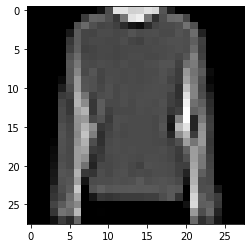

Label: 2
Category: Pullover


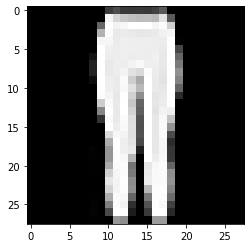

Label: 1
Category: Trouser


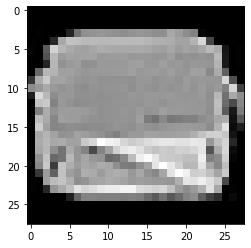

Label: 8
Category: Bag


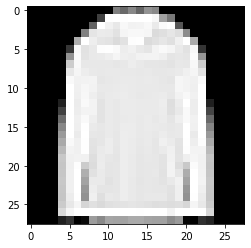

Label: 4
Category: Coat


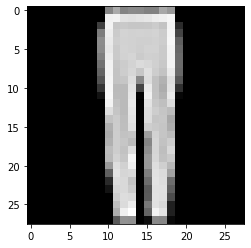

Label: 1
Category: Trouser


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
for fm_sample in fm_train.take(5):  
  image, label = fm_sample[0], fm_sample[1]

  plt.figure()
  plt.imshow(image.numpy()[:, :, 0].astype(np.float32), cmap=plt.get_cmap("gray"))
  plt.show()
  print("Label: %d" % label.numpy())
  print("Category: %s" % info.features["label"].names[label.numpy()])

In [ ]:
def scale(image, label):
  image = tf.cast(image, tf.float32)
  image /= 255.0

  return image, label

In [ ]:
def get_dataset(batch_size=256):
  train_dataset_scaled = fm_train.map(scale).shuffle(60000).batch(batch_size)
  test_dataset_scaled = fm_test.map(scale).batch(batch_size)
  val_dataset_scaled = fm_val.map(scale).batch(batch_size)
  return train_dataset_scaled, test_dataset_scaled, val_dataset_scaled

In [ ]:
def create_model():
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Conv2D(64, 2, padding='same', activation='relu', input_shape=(28, 28, 1)))
  model.add(tf.keras.layers.MaxPooling2D())
  model.add(tf.keras.layers.Dropout(0.3))

  model.add(tf.keras.layers.Conv2D(128, 2, padding='same', activation='relu'))
  model.add(tf.keras.layers.MaxPooling2D())
  model.add(tf.keras.layers.Dropout(0.3))

  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(256))
  model.add(tf.keras.layers.Activation('relu'))
  #model.add(tf.keras.layers.Dropout(0.5))
  model.add(tf.keras.layers.Dense(10))
  model.add(tf.keras.layers.Activation('softmax'))
  return model

In [ ]:
import tensorflow_model_optimization as tfmot

model = create_model()

quantize_model = tfmot.quantization.keras.quantize_model

q_aware_model = quantize_model(model)

q_aware_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

q_aware_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
quant_conv2d (QuantizeWrappe (None, 28, 28, 64)        451       
_________________________________________________________________
quant_max_pooling2d (Quantiz (None, 14, 14, 64)        1         
_________________________________________________________________
quant_dropout (QuantizeWrapp (None, 14, 14, 64)        1         
_________________________________________________________________
quant_conv2d_1 (QuantizeWrap (None, 14, 14, 128)       33155     
_________________________________________________________________
quant_max_pooling2d_1 (Quant (None, 7, 7, 128)         1         
_________________________________________________________________
quant_dropout_1 (QuantizeWra (None, 7, 7, 128)         1         
_________________________________________________________________
quant_flatten (QuantizeWrapp (None, 6272)              1

In [ ]:
logdir = os.path.join("/tmp/logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
  
train_dataset, test_dataset, val_dataset = get_dataset()
train_dataset.cache()
val_dataset.cache()

q_aware_model.fit(train_dataset,
          epochs=5,
          validation_data=val_dataset,
          callbacks=[tensorboard_callback])

Epoch 1/5
235/235 [==============================] - 9s 40ms/step - loss: 0.4868 - accuracy: 0.8274 - val_loss: 0.3645 - val_accuracy: 0.8723
Epoch 2/5
235/235 [==============================] - 9s 38ms/step - loss: 0.3066 - accuracy: 0.8925 - val_loss: 0.2961 - val_accuracy: 0.8917
Epoch 3/5
235/235 [==============================] - 9s 37ms/step - loss: 0.2678 - accuracy: 0.9041 - val_loss: 0.2931 - val_accuracy: 0.8887
Epoch 4/5
235/235 [==============================] - 9s 38ms/step - loss: 0.2427 - accuracy: 0.9136 - val_loss: 0.3141 - val_accuracy: 0.8813
Epoch 5/5
235/235 [==============================] - 9s 38ms/step - loss: 0.2174 - accuracy: 0.9203 - val_loss: 0.2451 - val_accuracy: 0.9120


In [ ]:
model.save('/tmp/fashion.hdf5')

In [ ]:
ls -alrt /tmp/fashion.hdf5

-rw-r--r-- 1 root root 6592256 May 15 13:06 /tmp/fashion.hdf5


In [ ]:
%tensorboard --logdir /tmp/logs

<IPython.core.display.Javascript object>

In [ ]:
 !nvidia-smi

Fri May 15 13:06:25 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P0    31W /  75W |   1429MiB /  7611MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [ ]:
q_aware_model.evaluate(test_dataset, verbose=0)

[0.3085697889328003, 0.8932856917381287]

In [ ]:
converter = tf.lite.TFLiteConverter..from_keras_model(q_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

quantized_tflite_model = converter.convert()

In [ ]:
quantized_model_size = len(quantized_tflite_model) / 1024
print('Quantized model size = %dKBs,' % quantized_model_size)

Quantized model size = 1609KBs,


In [ ]:
interpreter = tf.lite.Interpreter(model_content=quantized_tflite_model)
interpreter.allocate_tensors()

In [ ]:
input_tensor_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.tensor(interpreter.get_output_details()[0]["index"])

In [ ]:
interpreter.get_tensor_details()

[{'dtype': numpy.float32,
  'index': 0,
  'name': 'conv2d_input',
  'quantization': (0.0, 0),
  'quantization_parameters': {'quantized_dimension': 0,
   'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32)},
  'shape': array([ 1, 28, 28,  1], dtype=int32),
  'shape_signature': array([ 1, 28, 28,  1], dtype=int32),
  'sparsity_parameters': {}},
 {'dtype': numpy.float32,
  'index': 1,
  'name': 'sequential/quant_dense/BiasAdd/ReadVariableOp',
  'quantization': (0.0, 0),
  'quantization_parameters': {'quantized_dimension': 0,
   'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32)},
  'shape': array([256], dtype=int32),
  'shape_signature': array([256], dtype=int32),
  'sparsity_parameters': {}},
 {'dtype': numpy.float32,
  'index': 2,
  'name': 'sequential/quant_dense_1/BiasAdd/ReadVariableOp',
  'quantization': (0.0, 0),
  'quantization_parameters': {'quantized_dimension': 0,
   'scales': array([], dtype=float32),
   'zero_points': array([

In [ ]:
prediction_output = []
accurate_count = 0

for test_image in fm_test.map(scale):
    test_image_p = np.expand_dims(test_image[0], axis=0).astype(np.float32)
    interpreter.set_tensor(input_tensor_index, test_image_p)

    interpreter.invoke()
    out = np.argmax(output_index()[0])
    prediction_output.append(out)

    if out == test_image[1].numpy():
      accurate_count += 1


In [ ]:
accuracy = accurate_count/len(prediction_output)

In [ ]:
print(accuracy)

0.8921428571428571
